   year  month  day  week  temp_2  temp_1  average  actual  other
0  2024      1    1   Fri      45      45     45.6      45     29
1  2024      1    2   Sat      44      45     45.7      44     61
2  2024      1    3   Sun      45      44     45.8      41     56
3  2024      1    4   Mon      44      41     45.9      40     53
4  2024      1    5  Tues      41      40     46.0      44     41
数据维度： (348, 9)
         year       month         day      temp_2      temp_1     average  \
count   348.0  348.000000  348.000000  348.000000  348.000000  348.000000   
mean   2024.0    6.477011   15.514368   62.511494   62.560345   59.760632   
std       0.0    3.498380    8.772982   11.813019   11.767406   10.527306   
min    2024.0    1.000000    1.000000   35.000000   35.000000   45.100000   
25%    2024.0    3.000000    8.000000   54.000000   54.000000   49.975000   
50%    2024.0    6.000000   15.000000   62.500000   62.500000   58.200000   
75%    2024.0   10.000000   23.000000   71.000000 

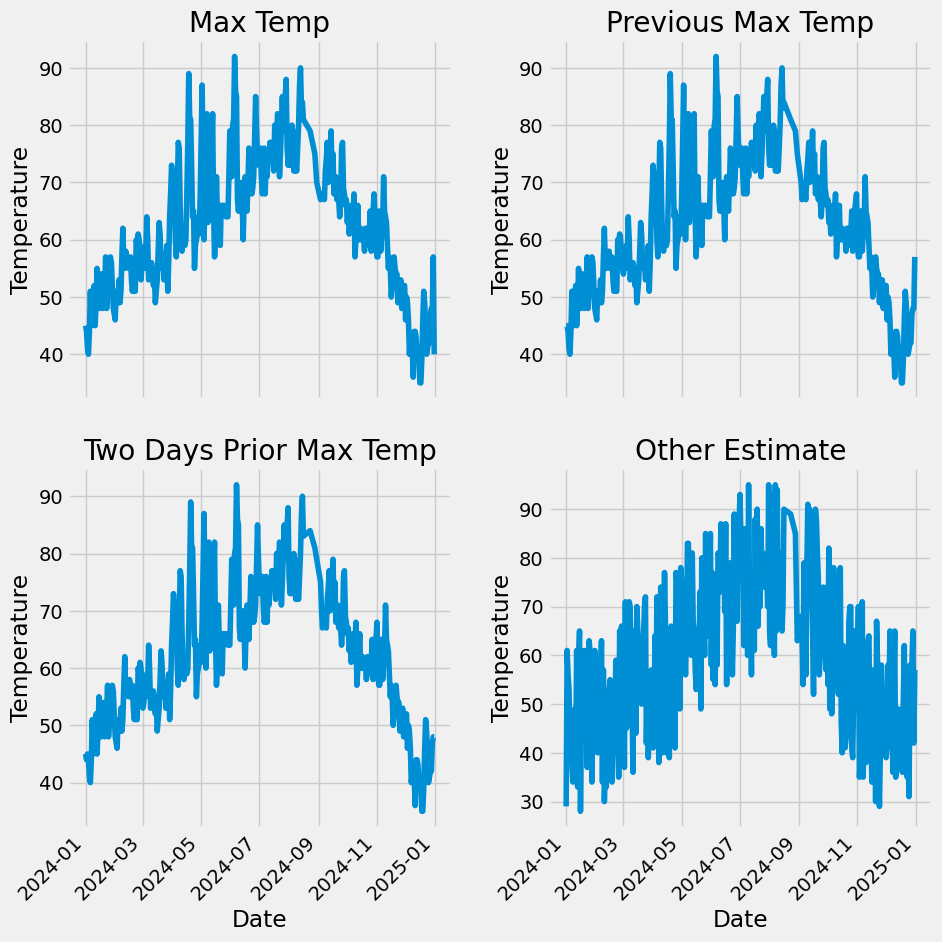

   year  month  day  temp_2  temp_1  average  actual  other  week_Fri  \
0  2024      1    1      45      45     45.6      45     29      True   
1  2024      1    2      44      45     45.7      44     61     False   
2  2024      1    3      45      44     45.8      41     56     False   
3  2024      1    4      44      41     45.9      40     53     False   
4  2024      1    5      41      40     46.0      44     41     False   

   week_Mon  week_Sat  week_Sun  week_Thurs  week_Tues  week_Wed  
0     False     False     False       False      False     False  
1     False      True     False       False      False     False  
2     False     False      True       False      False     False  
3      True     False     False       False      False     False  
4     False     False     False       False       True     False  
Shape of features after one-hot encoding: (348, 15)
训练集特征: (261, 14)
训练集标签: (261,)
测试集特征: (87, 14)
测试集标签: (87,)
MAPE: 6.011244187972058
mape: 6.229055723613811

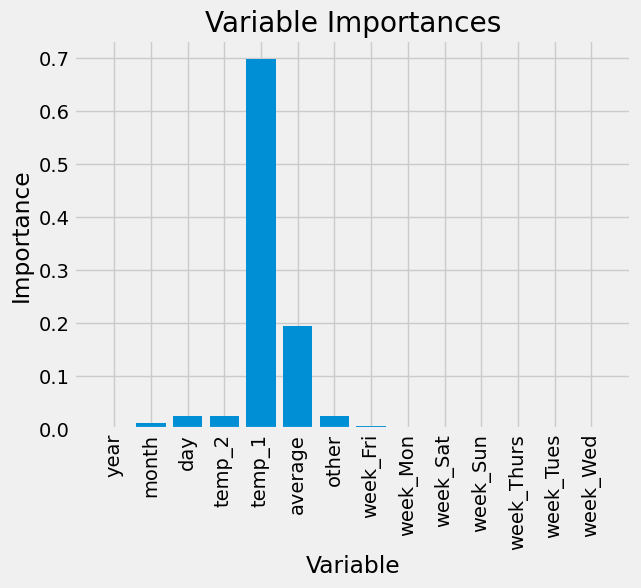

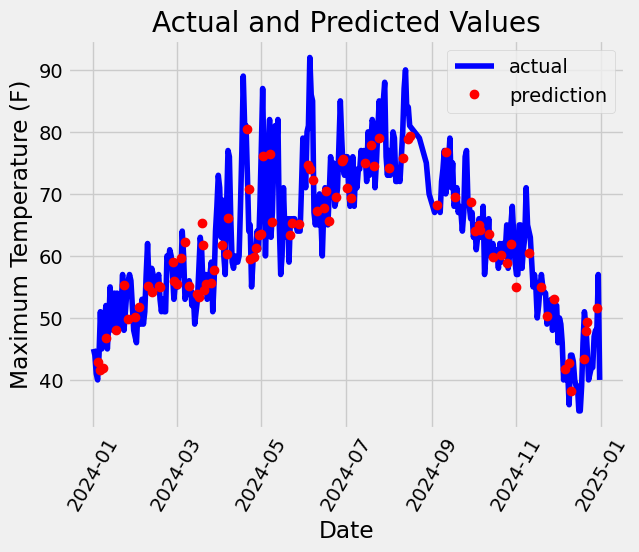

In [1]:
#数据读取
import pandas as pd

features = pd.read_csv('data/temps.csv')
print(features.head(5))
print('数据维度：', features.shape)

#统计指标
print(features.describe())

#处理时间数据
import datetime

#分别表示年，月，日
years = features['year']
months = features['month']
days = features['day']

#datetime格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year,month,day in zip(years,months,days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
print(dates[:5])

#准备画图
import matplotlib.pyplot as plt

#%matplotlib inline

#指定默认风格
plt.style.use('fivethirtyeight')

# 设置布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# 标签值
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# 昨天
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Max Temp')

# 前天
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# 其他
ax4.plot(dates, features['other'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Other Estimate')

plt.tight_layout(pad=2)
plt.show()

#独热编码
features = pd.get_dummies(features)
print(features.head(5))
print('Shape of features after one-hot encoding:',features.shape)

# 数据与标签
import numpy as np

# 标签
labels = np.array(features['actual'])

# 在特征中去掉标签
features = features.drop('actual', axis=1)

# 名字单独保存一下，以备后患
feature_list = list(features.columns)

# 转换成合适的格式
features = np.array(features)

# 数据集切分
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

print('训练集特征:', train_features.shape)
print('训练集标签:', train_labels.shape)
print('测试集特征:', test_features.shape)
print('测试集标签:', test_labels.shape)

# 导入算法
from sklearn.ensemble import RandomForestRegressor

# 建模
rf = RandomForestRegressor(n_estimators=1000, random_state=42)

# 训练
rf.fit(train_features, train_labels)

# 预测结果
predictions = rf.predict(test_features)

# 计算误差
errors = abs(predictions - test_labels)

# mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

print('MAPE:', np.mean(mape))

# 导入所需工具包
from sklearn.tree import export_graphviz
import pydot # pip install pydot

# 拿到其中的一棵树
tree = rf.estimators_[5]

# 导出成dot文件
export_graphviz(tree, out_file='tree.dot', feature_names=feature_list, rounded=True, precision=1)

# 绘图
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# 展示
graph.write_png('tree.png')

#print("The depth of this tree is:", tree.tree_.max_depth)

# 限制一下树模型
rf_small = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)
rf_small.fit(train_features, train_labels)

# 提取一颗树
tree_small = rf_small.estimators_[5]

# 保存
export_graphviz(tree_small, out_file='small_tree.dot', feature_names=feature_list, rounded=True, precision=1)

(graph,) = pydot.graph_from_dot_file('small_tree.dot')

graph.write_png('small_tree.png')

# 得到特征重要性
importances = list(rf.feature_importances_)

# 转换格式
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# 排序
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# 对应进行打印
#[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

# 选择最重要的那两个特征来试一试
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# 拿到这俩特征
important_indices = [feature_list.index('temp_1'), feature_list.index('average')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# 重新训练模型
rf_most_important.fit(train_important, train_labels)

# 预测结果
predictions = rf_most_important.predict(test_important)

errors = abs(predictions - test_labels)

# 评估结果
mape = np.mean(100 * (errors / test_labels))
print('mape:', mape)

# 转换成list格式
x_values = list(range(len(importances)))

# 绘图
plt.bar(x_values, importances, orientation='vertical')

# x轴名字
plt.xticks(x_values, feature_list, rotation='vertical')

# 图名
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

plt.show()

# 日期数据
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

# 转换日期格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# 创建一个表格来存日期和其对应的标签数值
true_data = pd.DataFrame(data={'date': dates, 'actual': labels})

# 同理，再创建一个来存日期和其对应的模型预测值
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]

test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

predictions_data = pd.DataFrame(data={'date': test_dates, 'prediction': predictions})

# 真实值
plt.plot(true_data['date'], true_data['actual'], 'b-', label='actual')

# 预测值
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label='prediction')
plt.xticks(rotation=60)
plt.legend()

# 图名
plt.xlabel('Date')
plt.ylabel('Maximum Temperature (F)')
plt.title('Actual and Predicted Values')

plt.show()